In [69]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import datetime

from models.aae import Encoder, Decoder, Discriminator, train, reconstruction_anomaly
from tools.viz import plot_anomaly_scores, plot_train_hist
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((0, 1))
        self.l_dim = 128
        self.profiles = ["CR2210"]
        # self.wsize = 5
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 200
        self.sample_interval = self.epochs // 4
        self.train_plots = True
        
        # create ouput dirs
        self.model_out = Path('./runs/aae/' + time_id)
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["aae", "joint", "minmax", "test"]
        self.desc = "CR2210"
        self.type = "AAE"
        
opts = Options()


# Setup Training Dataset

In [70]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataset.filter_profiles(opts.profiles)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]
Number of files to remove:  8593
Removed  8593  files


In [71]:
# dataset.plot(title="Joint Vars")

# Models

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
netEnc = Encoder(
    input_size=dataset.shape[1],
    l_dim=opts.l_dim,  
    device=device,
    slope=0.2
).to(device)
netDec = Decoder(
    output_size=dataset.shape[1],
    l_dim=opts.l_dim,
    slope=0.2
).to(device)

netD = Discriminator(
    l_dim=opts.l_dim,
    slope=0.2
).to(device)

Using device:  cuda:0


In [73]:
netEnc.train()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (mu): Linear(in_features=512, out_features=128, bias=True)
  (logvar): Linear(in_features=512, out_features=128, bias=True)
)

In [74]:
netDec.train()

Decoder(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1280, bias=True)
    (5): Sigmoid()
  )
)

In [75]:
netD.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [76]:
netD

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [77]:
logger = Logger([netEnc, netDec, netD], opts.model_out / f"{time_id}.md", vars(opts))

# Training

In [78]:
G_losses, D_losses = train(netEnc, netDec, netD, dataloader, opts, device)

Starting Training Loop...


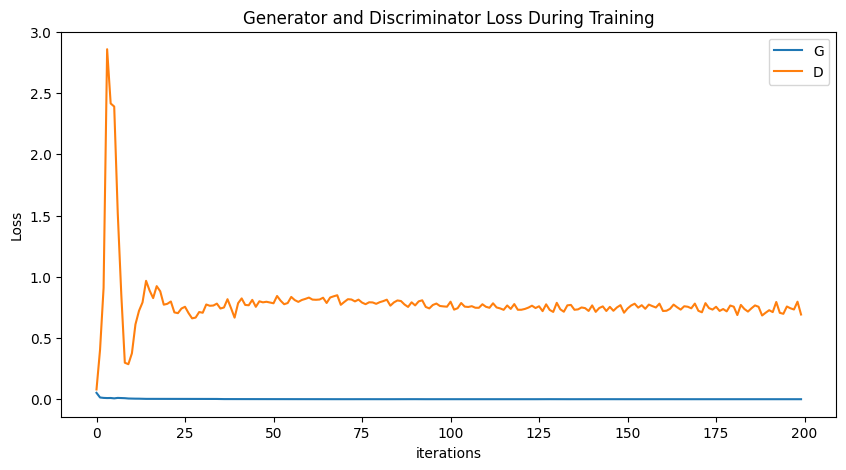

In [79]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [80]:

netEnc.train(False)
netDec.train(False)
netD.train(False)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/aae/0323-2048")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netEnc.load_state_dict(torch.load(opts_eval.models_dir / 'Enc.pth'))
netDec.load_state_dict(torch.load(opts_eval.models_dir / 'Dec.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D.pth'))

<All keys matched successfully>

In [81]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
removed = eval_dataset.filter_profiles(opts.profiles)

eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]
Number of files to remove:  9298
Removed  9298  files


## Reconstruction Error

In [82]:
scores = []
loss_fn = nn.MSELoss(reduction="none")
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    errG = loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores.append((filename, error))

Anomaly Threshold:  0.0006966925575397909
Found 24 anomalies


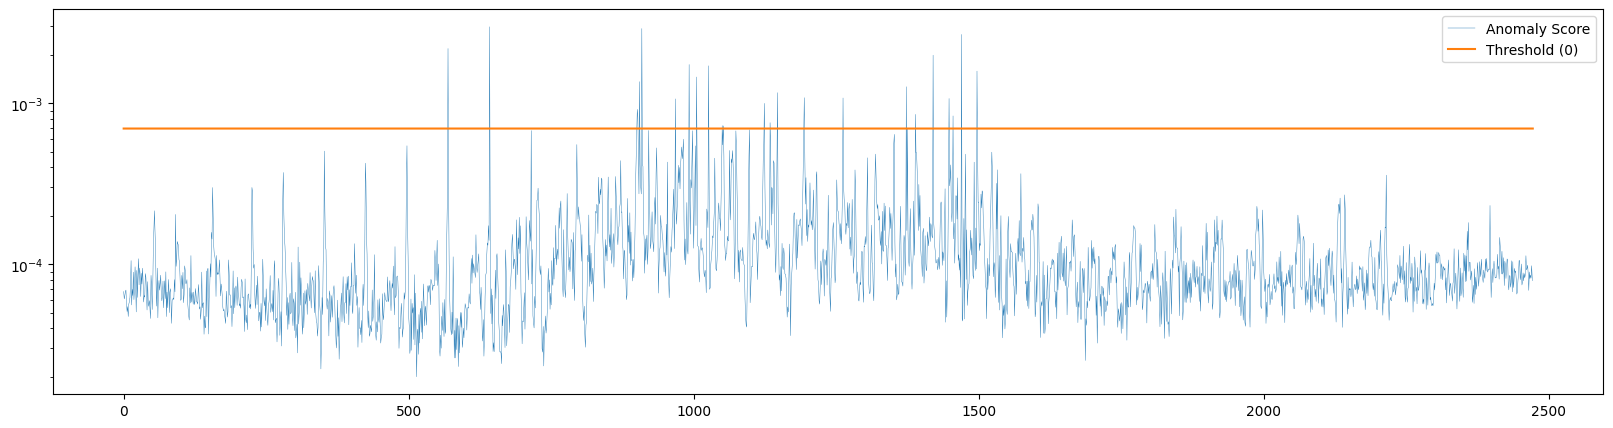

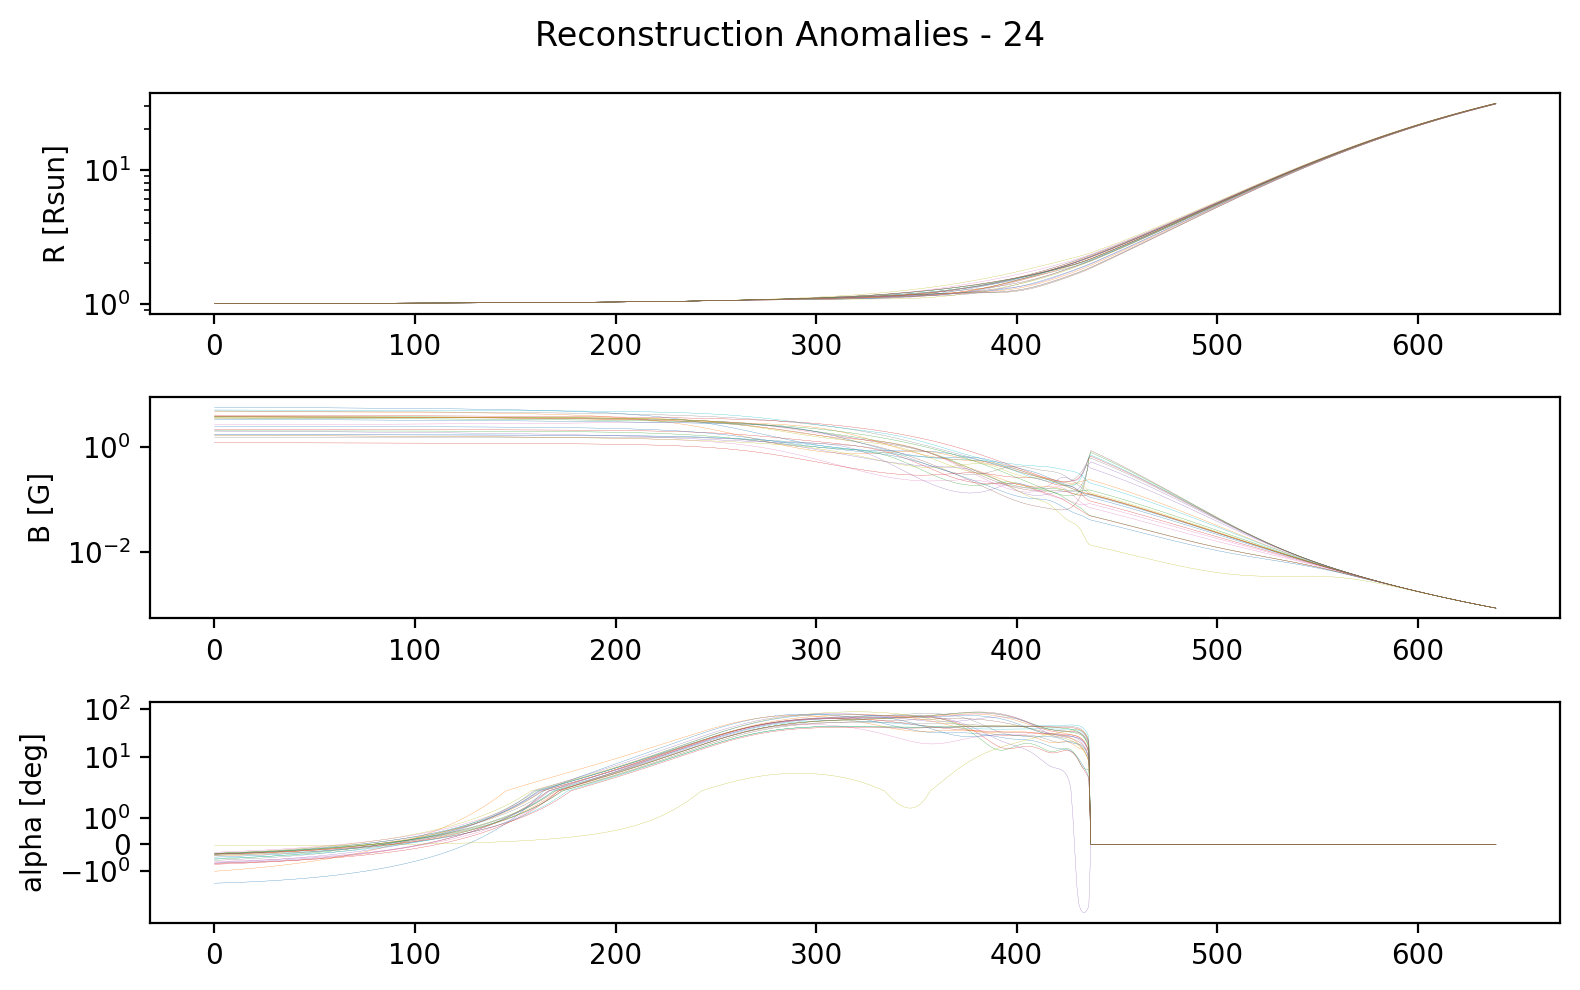

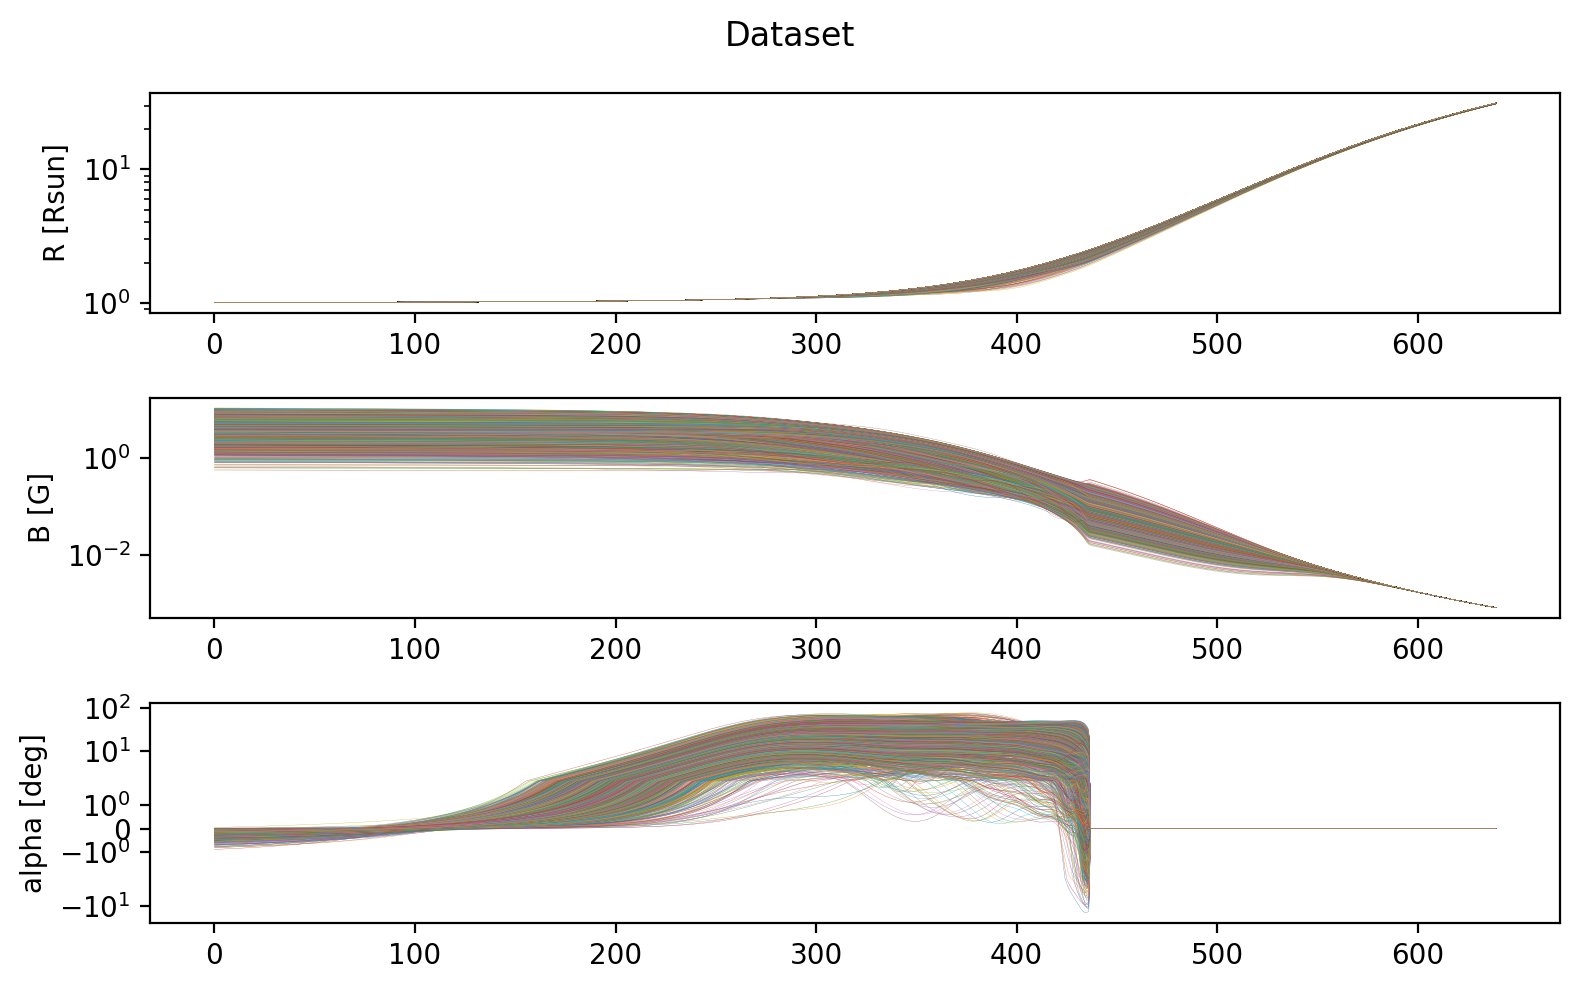

In [83]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.01, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Reconstruction", normal_plot=True, exclude=removed)

## Reconstruction + Discriminator

In [84]:
scores_discr = []
loss_fn = nn.MSELoss(reduction="none")
criterion = nn.BCELoss()

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = 0.1 * criterion(netD(enc_x), real_labels) + 0.9 * loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        # print(sample, filename)
        scores_discr.append((filename, error))

Anomaly Threshold:  0.06927816
Found 98 anomalies


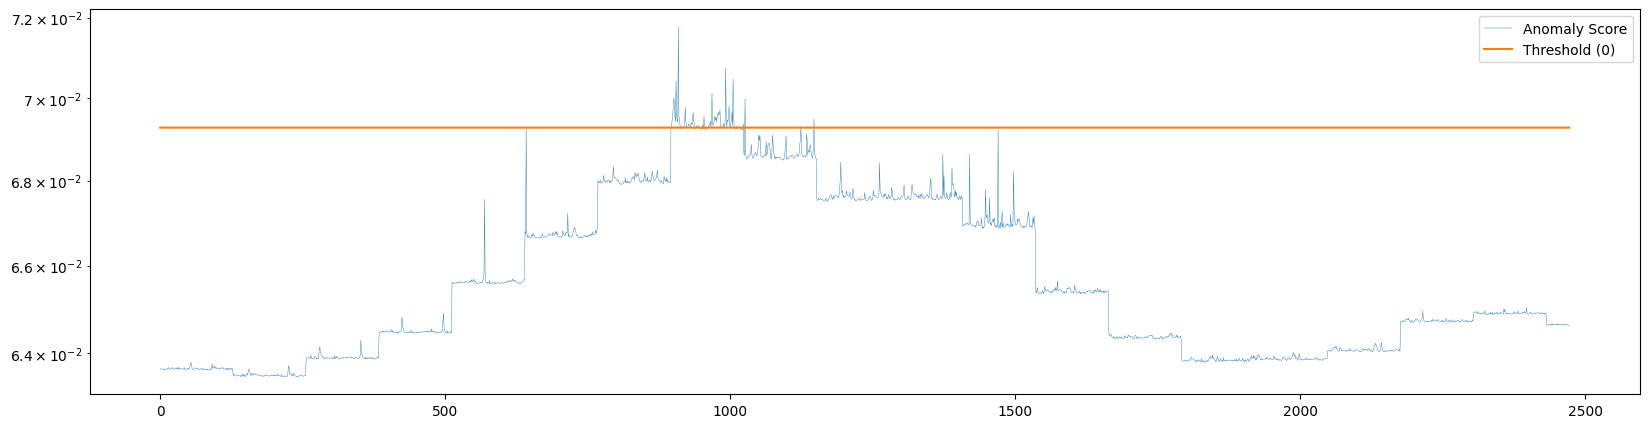

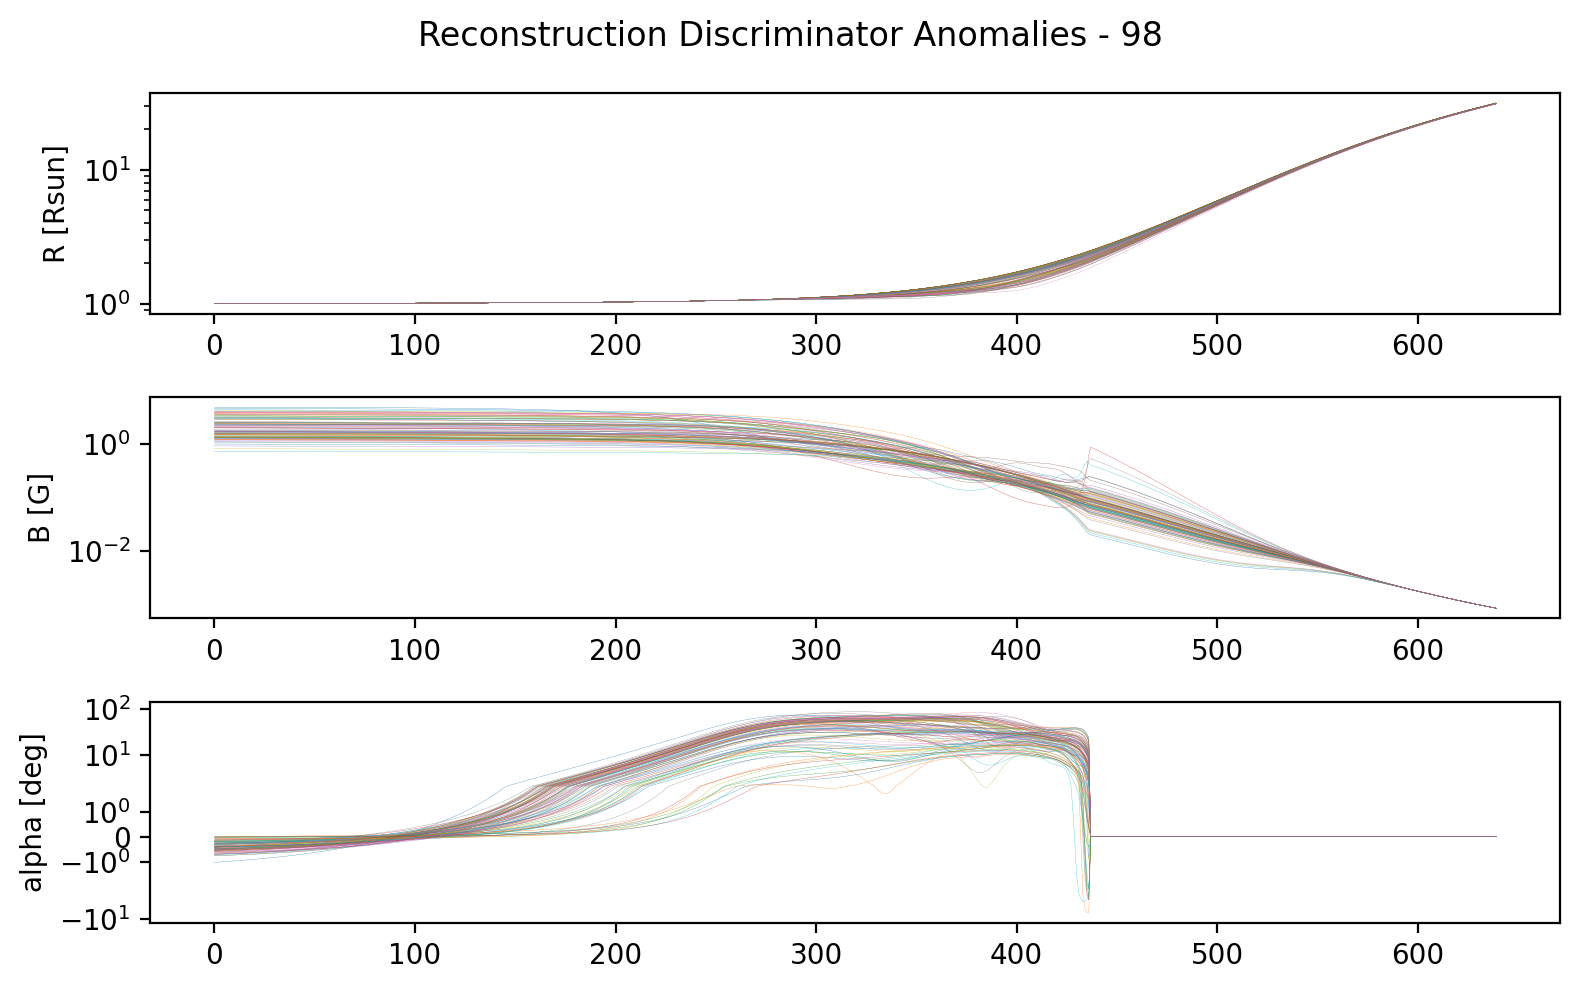

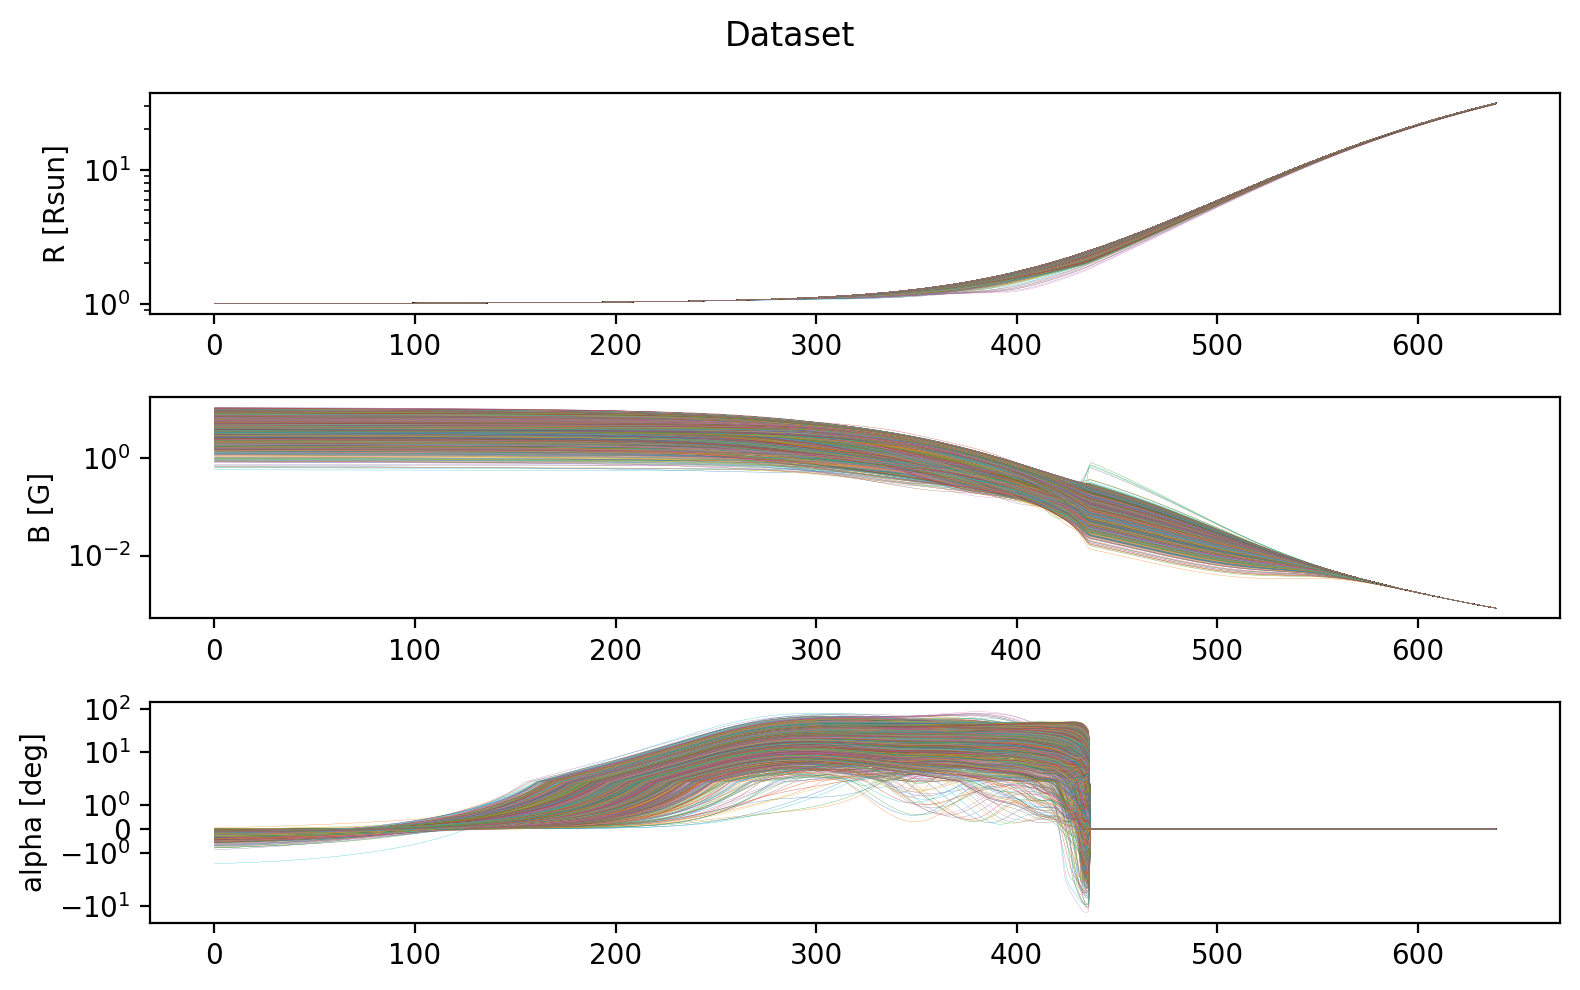

In [85]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.04, opts.data_path, opts_eval.models_dir /  f"img/reconstr_discr_scores", 
                        scale="log", method="Reconstruction Discriminator", normal_plot=True, exclude=removed)